## Logistic Regression with Bagging

Overall mean difference (Plain Logistic Regression, averaged per test point over LOO): 0.023856221152419522
Overall mean difference (Bagging, averaged per test point over LOO): 0.051470348368233956


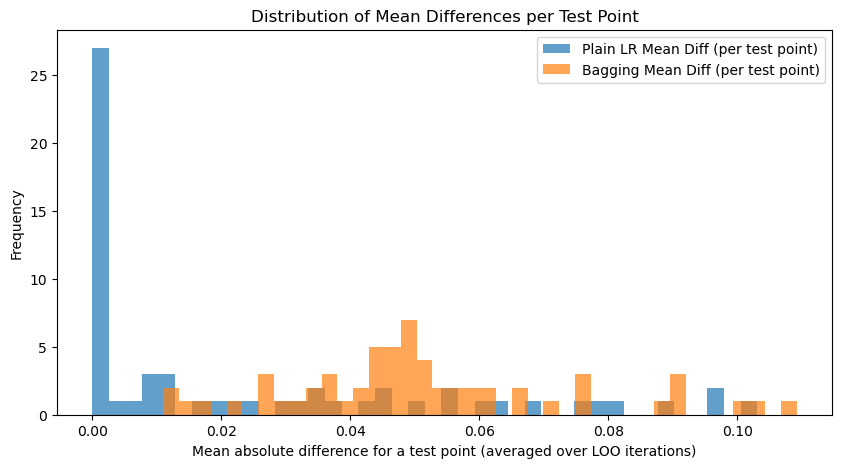

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# ----------------------------------------------------
# 1. Generate a synthetic binary classification dataset
#    and split into train/test sets
# ----------------------------------------------------
X, y = make_classification(
    n_samples=300,
    n_features=500,
    n_informative=500,
    n_redundant=0,
    random_state=43
)

# 80% train, 20% test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

n_train = X_train.shape[0]
n_test = X_test.shape[0]

# ----------------------------------------------------
# 2. Train the Full Model (Plain Logistic Regression) on the entire training set
# ----------------------------------------------------
lr_full = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_full.fit(X_train, y_train)

# Get full-model predictions on the TEST set (probabilities for the positive class)
preds_full_test = lr_full.predict_proba(X_test)[:, 1]

# ----------------------------------------------------
# 3. Leave-One-Out (LOO) for Plain Logistic Regression
#    Compute differences per test point, then average over LOO iterations
# ----------------------------------------------------
# Create an array to store differences for each LOO iteration (rows) and each test point (columns)
diffs_lr_test_all = np.zeros((n_train, n_test))

for i in range(n_train):
    # Remove the i-th sample from the training set
    X_train_loo = np.delete(X_train, i, axis=0)
    y_train_loo = np.delete(y_train, i, axis=0)
    
    # Retrain logistic regression on n_train - 1 samples
    lr_loo = LogisticRegression(solver='lbfgs', max_iter=1000)
    lr_loo.fit(X_train_loo, y_train_loo)
    
    # Predict on the entire TEST set
    preds_loo_test = lr_loo.predict_proba(X_test)[:, 1]
    
    # Compute absolute differences for each test point and store in row i
    diffs_lr_test_all[i, :] = np.abs(preds_full_test - preds_loo_test)

# For each test point, average the differences over all LOO iterations
mean_diffs_per_test_lr = np.mean(diffs_lr_test_all, axis=0)
overall_mean_diff_lr = np.mean(mean_diffs_per_test_lr)
print("Overall mean difference (Plain Logistic Regression, averaged per test point over LOO):", overall_mean_diff_lr)

# ----------------------------------------------------
# 4. Logistic Regression with Bagging (Sub-bagging)
#    (a) Build the full ensemble on the entire training set
# ----------------------------------------------------
number_of_bags = 50                  # Number of bag models in the ensemble
subsample_size = int(0.5 * n_train)   # Use 80% of the training data for each bag

ensemble_preds_full_test = np.zeros((n_test, number_of_bags))
for b in range(number_of_bags):
    # Subsample indices (without replacement)
    idxs = np.random.choice(n_train, size=subsample_size, replace=False)
    X_sub = X_train[idxs]
    y_sub = y_train[idxs]
    
    lr_bag = LogisticRegression(solver='lbfgs', max_iter=1000)
    lr_bag.fit(X_sub, y_sub)
    
    # Predict on the entire TEST set for bag b
    ensemble_preds_full_test[:, b] = lr_bag.predict_proba(X_test)[:, 1]

# Average the bag predictions to get the ensemble's full-model predictions
preds_full_bag_test = ensemble_preds_full_test.mean(axis=1)

# ----------------------------------------------------
# 5. Leave-One-Out (LOO) for the Bagging Ensemble
#    Compute differences per test point, then average over LOO iterations
# ----------------------------------------------------
diffs_bag_test_all = np.zeros((n_train, n_test))

for i in range(n_train):
    # Remove the i-th sample from the training set
    X_train_loo = np.delete(X_train, i, axis=0)
    y_train_loo = np.delete(y_train, i, axis=0)
    
    # Build an ensemble on the reduced training set
    ensemble_preds_loo_test = np.zeros((n_test, number_of_bags))
    for b in range(number_of_bags):
        # Subsample indices from the reduced training set
        idxs = np.random.choice(n_train - 1, size=subsample_size, replace=False)
        X_sub = X_train_loo[idxs]
        y_sub = y_train_loo[idxs]
        
        lr_bag_loo = LogisticRegression(solver='lbfgs', max_iter=1000)
        lr_bag_loo.fit(X_sub, y_sub)
        
        # Predict on the entire TEST set for bag b (LOO version)
        ensemble_preds_loo_test[:, b] = lr_bag_loo.predict_proba(X_test)[:, 1]
    
    # Average the predictions from the LOO ensemble for this iteration
    preds_loo_bag_test = ensemble_preds_loo_test.mean(axis=1)
    
    # Compute the absolute differences (for each test point)
    diffs_bag_test_all[i, :] = np.abs(preds_full_bag_test - preds_loo_bag_test)

# For each test point, average the differences over all LOO iterations
mean_diffs_per_test_bag = np.mean(diffs_bag_test_all, axis=0)
overall_mean_diff_bag = np.mean(mean_diffs_per_test_bag)
print("Overall mean difference (Bagging, averaged per test point over LOO):", overall_mean_diff_bag)

# ----------------------------------------------------
# 6. Plot the Distribution of the Mean Differences per Test Point
# ----------------------------------------------------
plt.figure(figsize=(10, 5))
plt.hist(mean_diffs_per_test_lr, bins=40, alpha=0.7, label='Plain LR Mean Diff (per test point)')
plt.hist(mean_diffs_per_test_bag, bins=40, alpha=0.7, label='Bagging Mean Diff (per test point)')
plt.xlabel("Mean absolute difference for a test point (averaged over LOO iterations)")
plt.ylabel("Frequency")
plt.title("Distribution of Mean Differences per Test Point")
plt.legend()
plt.show()
